# Moving Average Crossover2

### *Most of this was taken from "Python for Finance Tutorial For Beginners" which can be found here: [here](https://www.datacamp.com/community/tutorials/finance-python-trading).*

#### Other tutorials which might be helpful:
#### Time Series Analysis Tutorial with Python: https://www.datacamp.com/community/tutorials/time-series-analysis-tutorial
#### Multiple Plots in Matplotlib: https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/subplots_demo.html
#### Plots with different scales: https://matplotlib.org/gallery/api/two_scales.html
#### Log Returns https://www.rateofreturnexpert.com/log-return/
#### A tale of two returns https://www.portfolioprobe.com/2010/10/04/a-tale-of-two-returns/
#### Logarithmic Price Scale https://www.investopedia.com/terms/l/logarithmicscale.asp

In [1]:
%load_ext watermark
%watermark -p pandas,numpy,datetime,matplotlib,pandas_datareader,fix_yahoo_finance

pandas 0.23.4
numpy 1.15.4
datetime unknown
matplotlib 2.2.3
pandas_datareader 0.7.0
fix_yahoo_finance 0.0.22


In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
get_quandl_data=False
get_yahoo_data=False
start_date = '2006-10-1'
end_date = '2012-01-01'
ticker = 'aapl'
initial_capital= float(100000.0)


#### Get data from Yahoo Finance for one stock 

In [3]:
def get_yahoo_single(ticker, start_date, end_date):
    from pandas_datareader import data as pdr
    import fix_yahoo_finance
    #Get yahoo data for single stock for specified range
    #If you haven't already imported the Apple data from Yahoo, run this block, otherwise, skip to the next.
    if get_yahoo_data == True:
        #ticker_data = pdr.get_data_yahoo(ticker, start=datetime.datetime(2006, 10, 1), end=datetime.datetime(2012, 1, 1))
        ticker_data = pdr.get_data_yahoo(ticker, start=start_date, end=end_date) #Not necessary to use datetime lib, just format as YYYY-MM-DD string
        #ticker_data.head(), ticker_data.tail()
        ticker_data.to_csv('./data/%s_ohlc.csv' % (ticker)) #Export data as csv
    else:
        ticker_data = pd.read_csv('./data/%s_ohlc.csv' % (ticker), header=0, index_col='Date', parse_dates=True)
    return(ticker_data)

In [4]:
aapl = get_yahoo_single(ticker,start_date,end_date)
aapl.head(),aapl.tail()

(                 High        Low       Open      Close     Volume  Adj Close
 Date                                                                        
 2006-10-02  10.838572  10.614285  10.728572  10.694285  178159800   9.333044
 2006-10-03  10.707143  10.455714  10.635715  10.582857  197677200   9.235797
 2006-10-04  10.780000  10.451428  10.585714  10.768572  207270700   9.397876
 2006-10-05  10.880000  10.590000  10.647142  10.690000  170970800   9.329307
 2006-10-06  10.720000  10.544286  10.631429  10.602858  116739700   9.253254,
                  High        Low       Open      Close    Volume  Adj Close
 Date                                                                       
 2011-12-23  57.655716  57.070000  57.098572  57.618572  67349800  50.284481
 2011-12-27  58.441429  57.574287  57.585712  58.075714  66269000  50.683445
 2011-12-28  58.321430  57.334286  58.127144  57.520000  57165500  50.198467
 2011-12-29  57.950001  57.215714  57.628571  57.874287  53994500  5

#### Get data from Quandl for one stock

In [5]:
def get_quandl_single(ticker, start_date, end_date):
    import quandl
    quandl.ApiConfig.api_key = 'pLSz7YXyjD2pL8GeNXN3'
    if get_quandl_data == True:
        ticker_data = quandl.get("WIKI/%s" % ticker, start_date=start_date, end_date=end_date)
        ticker_data.to_csv('./data/%s_ohlc_adj.csv' % (ticker)) #Export data as csv
    else:
        ticker_data = pd.read_csv('./data/%s_ohlc_adj.csv' % (ticker), header=0, index_col='Date', parse_dates=True)
    return(ticker_data)

In [6]:
aapl_adj = get_quandl_single('aapl',start_date,end_date)
aapl_adj.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2006-10-02,75.10,75.870,74.30,74.86,25451400.0,0.0,1.0,9.651397,9.750352,9.548586,9.620553,178159800.0
2006-10-03,74.45,74.950,73.19,74.07,28239600.0,0.0,1.0,9.567863,9.632120,9.405935,9.519027,197677200.0
2006-10-04,74.10,75.462,73.16,75.38,29610100.0,0.0,1.0,9.522883,9.697919,9.402080,9.687381,207270700.0
2006-10-05,74.53,76.160,74.13,74.83,24424400.0,0.0,1.0,9.578144,9.787621,9.526738,9.616698,170970800.0
2006-10-06,74.42,75.040,73.81,74.22,16677100.0,0.0,1.0,9.564007,9.643686,9.485614,9.538304,116739700.0


<a id='tradingstrategy'></a>
## Building A Trading Strategy With Python

In [7]:
# Initialize the short and long windows
short_window = 40
long_window = 100

def get_signals(stock_price_df):
    # Initialize the `signals` DataFrame which holds moving avg data and "long" or "short" signal depending on whether 
    # the shorter mvg avg is above or below the longer mvg avg.
    signals = pd.DataFrame(index=stock_price_df.index) #Create new dataframe, using index from stock_price_df as index
    signals.sort_index(inplace=True)
    signals['signal'] = 0.0 #Create new column and set values to 0

    # Create short simple moving average over the short window
    signals['short_mavg'] = stock_price_df['Close'].rolling(window=short_window, min_periods=1, center=False).mean() #Note the min_periods which means that the mean calc uses a much shorter period until it reaches the number of periods for the mean

    # Create long simple moving average over the long window
    signals['long_mavg'] = stock_price_df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    # Set 'signals' value to 1 when short window avg crosses above long window. Set to -1 when opposite happens.
    # It looks like we don't set a signal until we have enough data for the short window. That means the long_window average is not actually calculated with the correct # of period yet.
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                                > signals['long_mavg'][short_window:], 1.0, 0.0)   
    #print(signals[:][short_window-5:])
    # Generate trading orders
    signals['action'] = signals['signal'].diff() #'set 'action' value to the value of the diff between the last 'signal' and the current one.
    # Basically, any time signal goes from 0 to 1, "action" gets set to 1 (buy). signal going from 1 to 0 causes "action" to be set to -1 (sell)
    signals.fillna(0.0, inplace=True)
    
    return(signals)

signals = get_signals(aapl)

In [8]:
(signals[:][short_window-5:]) # All columns and rows starting with index of short_window-5

,signal,short_mavg,long_mavg,action
Date,,,,
2006-11-20,0.0,11.324048,11.324048,0.0
2006-11-21,0.0,11.360077,11.360077,0.0
2006-11-22,0.0,11.400639,11.400639,0.0
2006-11-24,0.0,11.443956,11.443956,0.0
2006-11-27,0.0,11.477643,11.477643,0.0
2006-11-28,1.0,11.538179,11.517596,1.0
2006-11-29,1.0,11.601464,11.555612,0.0
2006-11-30,1.0,11.659607,11.591395,0.0
2006-12-01,1.0,11.718500,11.624448,0.0


In [9]:
#Just replace this with build_portfolio function
def get_positions(signals_df):
    positions = pd.DataFrame(index=signals_df.index).fillna(0.0) #Why another df? Just put this in portfolio df.
    #positions.sort_index(inplace=True)
    return(positions)
    
positions = get_positions(signals)
print(type(positions.index[0]))
print((positions.index))
print((positions.head()))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
DatetimeIndex(['2006-10-02', '2006-10-03', '2006-10-04', '2006-10-05',
               '2006-10-06', '2006-10-09', '2006-10-10', '2006-10-11',
               '2006-10-12', '2006-10-13',
               ...
               '2011-12-16', '2011-12-19', '2011-12-20', '2011-12-21',
               '2011-12-22', '2011-12-23', '2011-12-27', '2011-12-28',
               '2011-12-29', '2011-12-30'],
              dtype='datetime64[ns]', name='Date', length=1323, freq=None)
Empty DataFrame
Columns: []
Index: [2006-10-02 00:00:00, 2006-10-03 00:00:00, 2006-10-04 00:00:00, 2006-10-05 00:00:00, 2006-10-06 00:00:00]


In [10]:
def get_available_cash(day):
    day_index_loc = portfolio.index.get_loc(day) #returns the int index of the row
    prev_day_index_loc = day_index_loc - 1
    cash = portfolio.iloc[prev_day_index_loc]['cash'] #Get amount of cash from end of yesterday


In [11]:
def build_portfolio(signals):
    portfolio = pd.DataFrame(index=signals.index, columns=['positions','holdings','cash','totals','return']).fillna(0.0)

    #Loop through portfolio and determine positions (# shares) based on share price for each day, as well as holdings (price*shares), cash, etc
    d = 0
    for day in portfolio.index:
        #Determine available cash
        if d == 0:
            cash = initial_capital
            portfolio.loc[day]['cash'] = cash
        else:
            #cash = get_available_cash(day)
            cash = portfolio.iloc[portfolio.index.get_loc(day)-1]['cash'] #Get amount of cash from end of yesterday

        #print('{} cash: {}'.format(day,cash))
        price = aapl.loc[day]['Adj Close'] #Get day's closing price
        existing_shares = portfolio.iloc[portfolio.index.get_loc(day)-1]['positions'] #Get number of shares from end of yesterday
        #Check for trade signal
        if signals.loc[day]['action']==1: #Buy signal
            #existing_shares = portfolio.iloc[portfolio.index.get_loc(day)-1]['positions'] #Get number of shares from end of yesterday
            shares = int(cash / price)
            total_shares = existing_shares + shares
            transaction = shares * price
            #update positions df with number of shares to buy and price
            print("{} BUY {} shares at ${} for a total transaction of -${}".format(day,shares,price,transaction))
            #Adjust cash balance
            cash = cash - transaction
            portfolio.loc[day]['positions'] = total_shares
            portfolio.loc[day]['holdings'] = transaction
            portfolio.loc[day]['totals'] = cash + transaction
            #print('Totals: {}'.format(portfolio.loc[day]['totals']))
            #print('{}\tCash: {}\tHoldings: {}\tTotal: {}'.format(day,cash,(portfolio.loc[day]['holdings']),(portfolio.loc[day]['totals'])))
        elif signals.loc[day]['action']==-1: #Sell signal
            shares = existing_shares
            transaction = existing_shares * price
            #update positions df with number of shares to buy and price
            print("{} SELL {} shares at ${} for a total transaction of ${}".format(day,shares,price,transaction))
            #print('Total shares: {}'.format(0))
            #Adjust cash balance
            cash = cash + transaction
            portfolio.loc[day]['positions'] = 0
            portfolio.loc[day]['holdings'] = portfolio.loc[day]['holdings'] - transaction
            portfolio.loc[day]['totals'] = cash #Equal to cash since we sold everything
            #print('Totals: {}'.format(portfolio.loc[day]['totals']))
            #print('{}\tCash: {}\tHoldings: {}\tTotal: {}'.format(day,cash,(portfolio.loc[day]['holdings']),(portfolio.loc[day]['totals'])))
        else:
            #pass
            #shares = portfolio.iloc[portfolio.index.get_loc(day)-1]['positions'] #Set current shares equal to yesterday's since no transactions today
            portfolio.loc[day]['positions'] = existing_shares
            portfolio.loc[day]['holdings'] = existing_shares * price
            portfolio.loc[day]['totals'] = cash + (existing_shares * price)
            #print('{}\tCash: {}\tHoldings: {}\tTotal: {}'.format(day,cash,(portfolio.loc[day]['holdings']),(portfolio.loc[day]['totals'])))
            
        #Set today's remaining cash amount    
        portfolio.loc[day]['cash'] = cash
        d += 1
    start_val = initial_capital
    end_val = portfolio.iloc[-1]['totals']
    gain = end_val - start_val
    pct_gain = (gain / start_val)*100
    print('*** Portfolio Value ***\nStarting: ${}\tEnding: ${}\tTotal Gain: ${}\tPercent Gain: {}%'.format(start_val, end_val, gain, pct_gain))
    return(portfolio)

portfolio = build_portfolio(signals)

2006-11-28 00:00:00 BUY 8736 shares at $11.446256637573242 for a total transaction of -$99994.49798583984
2008-02-06 00:00:00 SELL 8736.0 shares at $15.210143089294435 for a total transaction of $132875.8100280762
2008-05-06 00:00:00 BUY 5710 shares at $23.271522521972656 for a total transaction of -$132880.39360046387
2008-08-11 00:00:00 SELL 5710.0 shares at $21.638294219970703 for a total transaction of $123554.65999603271
2009-03-19 00:00:00 BUY 9752 shares at $12.66930103302002 for a total transaction of -$123551.02367401123
2010-08-24 00:00:00 SELL 9752.0 shares at $29.91287422180176 for a total transaction of $291710.3494110108
2010-09-17 00:00:00 BUY 8497 shares at $34.33129501342773 for a total transaction of -$291713.0137290954
2011-05-11 00:00:00 SELL 8497.0 shares at $43.290321350097656 for a total transaction of $367837.8605117798
2011-05-12 00:00:00 BUY 8513 shares at $43.20803451538086 for a total transaction of -$367829.99782943726
2011-05-16 00:00:00 SELL 8513.0 shares

### Plot stock price and portfolio value on two different scales

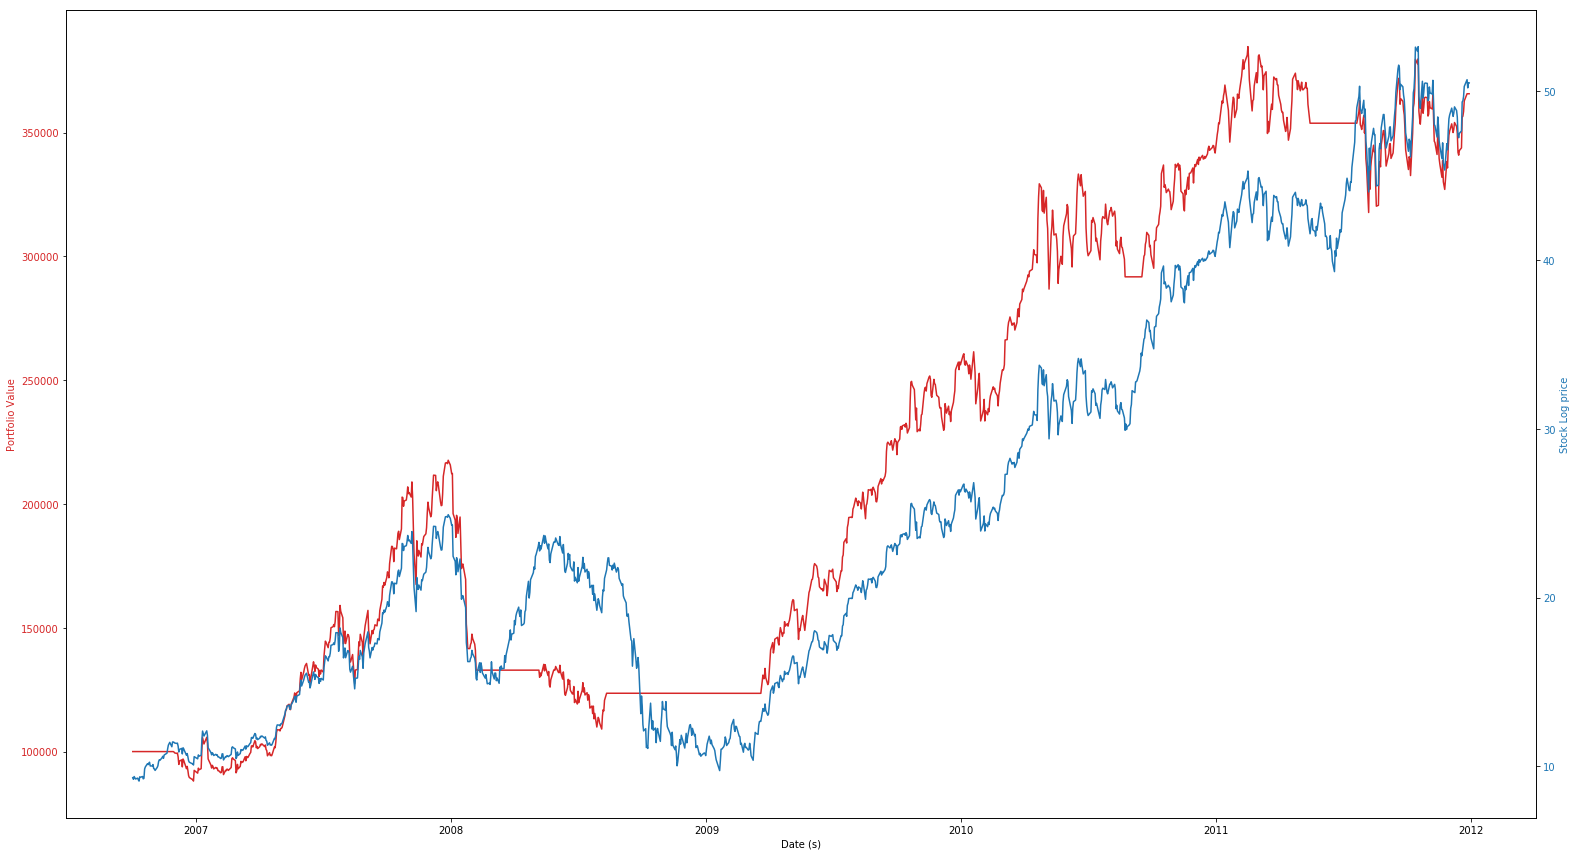

In [12]:
fig, ax1 = plt.subplots(figsize=(22,12))
portfolio_tot = portfolio['totals']
price_data = aapl['Adj Close']



color = 'tab:red'
ax1.set_xlabel('Date (s)')
ax1.set_ylabel('Portfolio Value', color=color)
ax1.plot(portfolio_tot, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Stock Log price', color=color)  # we already handled the x-label with ax1
ax2.plot(price_data, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Plot everything including buys and sells

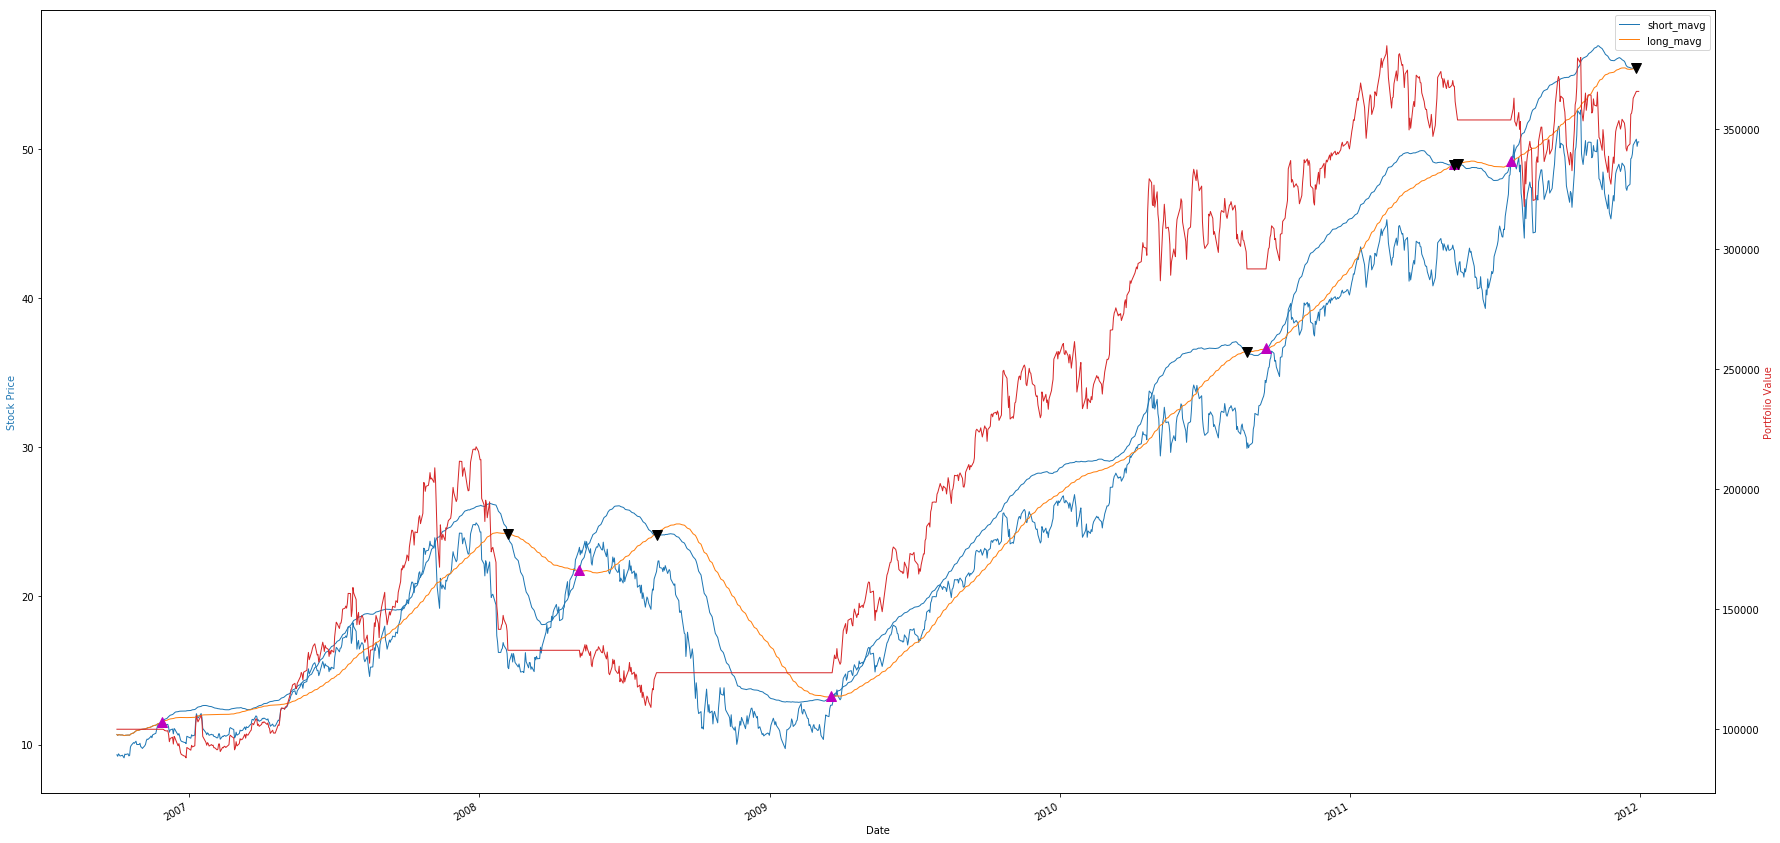

In [13]:
# Initialize the plot figure
fig, ax1 = plt.subplots(figsize=(30,16))
#fig = plt.figure(figsize=[28,14])

# Add a subplot and label for y-axis
#ax1 = fig.add_subplot(111,  ylabel='Price in $') # Not sure what 111 is

# Plot the closing price
color = 'tab:blue'
aapl['Adj Close'].plot(ax=ax1, color=color, lw=1.)


# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=1.)

# Plot the buy signals
ax1.plot(signals.loc[signals.action == 1.0].index, 
         signals.short_mavg[signals.action == 1.0],
         '^', markersize=10, color='m')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.action == -1.0].index, 
         signals.short_mavg[signals.action == -1.0],
         'v', markersize=10, color='k')
ax1.set_ylabel('Stock Price', color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
portfolio['totals'].plot(ax=ax2, color=color, lw=1.)
ax2.set_xlabel('Date (s)')
ax2.set_ylabel('Portfolio Value', color=color)


# Show the plot
plt.show()

### Volatility Calculation

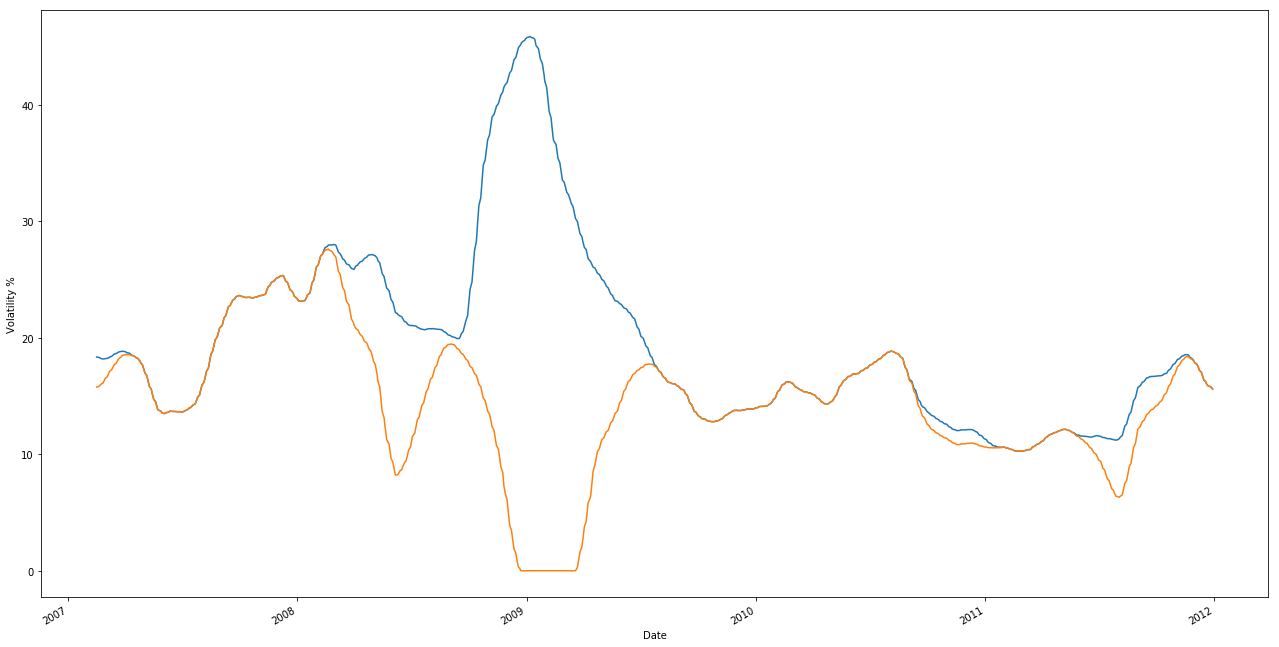

In [14]:
# Define the minumum of periods to consider 
min_periods = 75 
rolling_period = 20 #Smooth out the volatility plot

fig, ax1 = plt.subplots(figsize=(22,12))
ax1.set_xlabel('Date (s)')
ax1.set_ylabel('Volatility %', color='black')


stock_daily_pct_change = (aapl['Adj Close'].pct_change())*100
stock_vol = stock_daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods)
#aapl['vol'] = stock_daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) #Add volatility column to df

portfolio_daily_pct_change = (portfolio['totals'].pct_change())*100
portfolio_vol = portfolio_daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods)

# Calculate the volatility
# Plot the volatility


stock_vol.rolling(rolling_period).mean().plot(ax=ax1,label='Stock Volatility')
portfolio_vol.rolling(rolling_period).mean().plot(ax=ax1,label='Portfolio Volatility')

plt.show()

## Calculate Sharpe Ratio for portfolio and holding

In [15]:
portfolio['returns'] = portfolio['totals'].pct_change()
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())
print('Sharpe Ratio: {}'.format(sharpe_ratio))

Sharpe Ratio: 1.0141075733866358


## Calculate Maximum Drawdown for the stock

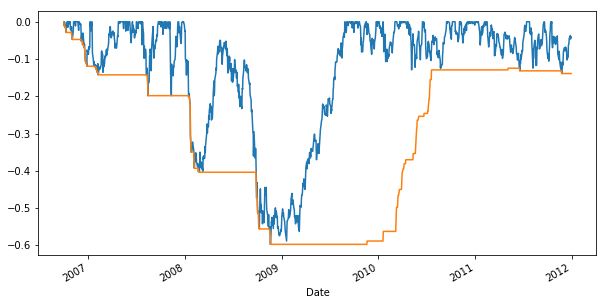

In [16]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day
rolling_max = aapl['Adj Close'].rolling(window, min_periods=1).max()

daily_drawdown = aapl['Adj Close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot(figsize=[10,5])
max_daily_drawdown.plot()

# Show the plot
plt.show()

## Calculate Compound Annual Growth Rate (CAGR)

In [17]:
# Get the number of days in `aapl`
days = (aapl.index[-1] - aapl.index[0]).days

# Calculate the CAGR 
aapl_cagr = ((((aapl['Adj Close'][-1]) / aapl['Adj Close'][1])) ** (365.0/days)) - 1
#strategy_cagr=()
#returns = portfolio['returns']
portfolio_cagr = portfolio['returns'].sum()** (365.0/days) - 1
# Print CAGR

print('Stock CAGR:\t{}'.format(aapl_cagr)) # THIS IS WRONG
print('Portfolio CAGR:\t{} <--- This is wrong'.format(portfolio_cagr)) # THIS IS WRONG
#pct_gain

Stock CAGR:	0.38234461393881247
Portfolio CAGR:	0.0814194835416151 <--- This is wrong
